In [2]:
import pandas as pd
import json
from config import *
from ppp_prediction.utils import load_data
from ppp_prediction.model import fit_best_model
import pickle


import matplotlib.pyplot as plt
import seaborn as sns
from ppp_prediction.plot.utils import save_fig

params = {
    "axes.labelsize": 14,  # fontsize for x and y labels (was 10)
    "font.size": 8,  # was 10
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "text.usetex": False,
    "figure.figsize": [5, 5],
    "font.family": "Calibri",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 2,
    # set title fontsize
    "axes.titlesize": 15,
    "axes.titleweight": "bold",
    "figure.titlesize": 15,
    # label
    "axes.labelweight": "bold",
}

plt.rcParams.update(params)

%config InlineBackend.figure_format = "svg"
%config InlineBackend.print_figure_kwargs = {"dpi" : 300}

figdir = outputDir / "fig/04-Model"

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2025-02-12 20:03:03,361	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-12 20:03:03,788	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-12 20:03:03,870	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
diseaserawDir = dataDir / "label"
modelSaveDir = outputDir / "03-EnvModel"


def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [4]:
clinical_risk_dict = json.loads(open(dataDir / "clinical_risk_dict.json").read())
clinical_risk_dict["AgeSex"] = ["age", "sex"]
clinical_risk_dict

{'ASCVD': ['age',
  'sex',
  'cholesterol',
  'hdl_cholesterol',
  'systolic_blood_pressure_medical_adjust',
  'antihypertensives',
  'diabetes2',
  'smoking_status'],
 'FINDRISC': ['age',
  'sex',
  'daily_physical_activity',
  'fh_diabetes',
  'body_mass_index_bmi',
  'waist_circumference',
  'antihypertensives'],
 'CAIDE': ['age',
  'sex',
  'daily_physical_activity',
  'education_years',
  'body_mass_index_bmi',
  'cholesterol'],
 'PANEL': ['body_mass_index_bmi',
  'waist_hip_ratio',
  'waist_circumference',
  'weight',
  'standing_height',
  'systolic_blood_pressure_medical_adjust',
  'cholesterol',
  'ldl_direct_medical_adjust',
  'hdl_cholesterol',
  'triglycerides_medical_adjust',
  'glucose',
  'glycated_haemoglobin_hba1c',
  'creatinine',
  'cystatin_c',
  'urea',
  'urate',
  'aspartate_aminotransferase',
  'alanine_aminotransferase',
  'alkaline_phosphatase',
  'albumin',
  'creactive_protein',
  'red_blood_cell_erythrocyte_count',
  'white_blood_cell_leukocyte_count',
  'p

In [5]:
# Prot_train = load_data(dataDir / "imputeData" / "Prot_train.feather")
# held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
# held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")
# print(RF_train.info())

RF_train = load_data(dataDir / "imputeData" / "RF_train.feather")
held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")
print(RF_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473367 entries, 0 to 473366
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   eid                                         473367 non-null  object 
 1   age                                         473367 non-null  Float64
 2   sex                                         473367 non-null  Int64  
 3   smoking_status                              473367 non-null  Int64  
 4   alcohol_intake_frequency                    473367 non-null  Int64  
 5   daily_physical_activity                     473367 non-null  Int64  
 6   education_years                             473367 non-null  float64
 7   daily_healthy_food                          473367 non-null  Int64  
 8   fh_diabetes                                 473367 non-null  Int64  
 9   diabetes2                                   473367 non-null  Int64  
 

## Clinical Model 

In [6]:
RF_train = load_data(dataDir / "imputeData" / "RF_train.feather")
held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")
print(RF_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473367 entries, 0 to 473366
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   eid                                         473367 non-null  object 
 1   age                                         473367 non-null  Float64
 2   sex                                         473367 non-null  Int64  
 3   smoking_status                              473367 non-null  Int64  
 4   alcohol_intake_frequency                    473367 non-null  Int64  
 5   daily_physical_activity                     473367 non-null  Int64  
 6   education_years                             473367 non-null  float64
 7   daily_healthy_food                          473367 non-null  Int64  
 8   fh_diabetes                                 473367 non-null  Int64  
 9   diabetes2                                   473367 non-null  Int64  
 

In [7]:
dataDir

PosixPath('V4/data')

In [8]:
print(RF_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473367 entries, 0 to 473366
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   eid                                         473367 non-null  object 
 1   age                                         473367 non-null  Float64
 2   sex                                         473367 non-null  Int64  
 3   smoking_status                              473367 non-null  Int64  
 4   alcohol_intake_frequency                    473367 non-null  Int64  
 5   daily_physical_activity                     473367 non-null  Int64  
 6   education_years                             473367 non-null  float64
 7   daily_healthy_food                          473367 non-null  Int64  
 8   fh_diabetes                                 473367 non-null  Int64  
 9   diabetes2                                   473367 non-null  Int64  
 

In [9]:
diseaserawDir = dataDir / "label"
modelSaveDir = outputDir / "03-EnvModel"


def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [10]:
drop_dict = {
    "T2D": ["Glucose", "glucose", "glycated_haemoglobin_hba1c"],
    "Stroke": None,
    "Heart_Failure": None,
    "Coronary_Artery_Disease": None,
    "Chronic_kidney_disease": ["Creatinine", "creatinine"],
    "Atrial_fibrillation_or_flutter": None,
    "PAD": None,
    "Hypertension": None,
    "Venous_Thromboembolism": None,
    "CMD": ["Creatinine", "creatinine", "Glucose", "glucose"],
}


def drop_value_from_list(l, v=None):
    if v is None:
        return l
    if len(v) == 0:
        return l
    will_drop = []
    will_keep = []
    for i in l:
        if i in v:
            will_drop.append(i)
        else:
            will_keep.append(i)
    print(f"will drop {will_drop}")
    return will_keep
    # will_drop.extend(drop_dict[i])

In [11]:
list(diseaserawDir.glob("*"))

[PosixPath('V4/data/label/Coronary_Artery_Disease.feather'),
 PosixPath('V4/data/label/Heart_Failure.feather'),
 PosixPath('V4/data/label/Hypertension.feather'),
 PosixPath('V4/data/label/Stroke.feather'),
 PosixPath('V4/data/label/Atrial_fibrillation_or_flutter.feather'),
 PosixPath('V4/data/label/Chronic_kidney_disease.feather'),
 PosixPath('V4/data/label/PAD.feather'),
 PosixPath('V4/data/label/Venous_Thromboembolism.feather'),
 PosixPath('V4/data/label/T2D.feather')]

In [12]:
from collections import defaultdict
# from ppp_prediction.model import run_glmnet

disease_dict = defaultdict(dict)
for disease_dir in diseaserawDir.glob("*"):
    disease_name = disease_dir.stem
    if disease_name not in ["Coronary_Artery_Disease"]:
        continue

    disease_df = load_data(disease_dir)

    disease_train = disease_df.merge(RF_train, on="eid", how="inner")
    disease_data_held_out_train = disease_df.merge(
        held_out_train, on="eid", how="inner"
    )
    disease_data_held_out_test = disease_df.merge(held_out_test, on="eid", how="inner")

    disease_modelSaveDir = modelSaveDir / disease_name
    disease_modelSaveDir.mkdir(parents=True, exist_ok=True)
    if (disease_modelSaveDir / "disease_dict.pkl").exists():
        c_disease_dict = pickle.load(
            open(disease_modelSaveDir / "disease_dict.pkl", "rb")
        )
    else:
        final_need_cols = ["eid", "incident", "survTime", "date"]
        c_model_dict = {}

        # for name, combination in clinical_risk_dict.items():
        for name, combination in clinical_risk_dict.items():
            print(name)
            print(combination)
            if name not in ["PANEL"]:
                continue
            combination = drop_value_from_list(combination, drop_dict[disease_name])
            break

ASCVD
['age', 'sex', 'cholesterol', 'hdl_cholesterol', 'systolic_blood_pressure_medical_adjust', 'antihypertensives', 'diabetes2', 'smoking_status']
FINDRISC
['age', 'sex', 'daily_physical_activity', 'fh_diabetes', 'body_mass_index_bmi', 'waist_circumference', 'antihypertensives']
CAIDE
['age', 'sex', 'daily_physical_activity', 'education_years', 'body_mass_index_bmi', 'cholesterol']
PANEL
['body_mass_index_bmi', 'waist_hip_ratio', 'waist_circumference', 'weight', 'standing_height', 'systolic_blood_pressure_medical_adjust', 'cholesterol', 'ldl_direct_medical_adjust', 'hdl_cholesterol', 'triglycerides_medical_adjust', 'glucose', 'glycated_haemoglobin_hba1c', 'creatinine', 'cystatin_c', 'urea', 'urate', 'aspartate_aminotransferase', 'alanine_aminotransferase', 'alkaline_phosphatase', 'albumin', 'creactive_protein', 'red_blood_cell_erythrocyte_count', 'white_blood_cell_leukocyte_count', 'platelet_count', 'haemoglobin_concentration', 'haematocrit_percentage', 'mean_corpuscular_haemoglobin'

In [13]:
disease_train_sample = disease_train.dropna(subset=["incident", *combination]).groupby("incident").sample(n=5000)
disease_data_held_out_train = disease_data_held_out_train.dropna(
    subset=["incident", *combination]
)
X_train = disease_train_sample[combination]
y_train = disease_train_sample["incident"]
X_held_out_train = disease_data_held_out_train[combination]
y_held_out_train = disease_data_held_out_train["incident"]
disease_data_held_out_test = disease_data_held_out_test.dropna(
    subset=["incident", *combination]
)
X_held_out_test = disease_data_held_out_test[combination]
y_held_out_test = disease_data_held_out_test["incident"]

In [14]:
disease_train

,eid,event,incident,prevalent,survTime,date,recuit_date,followTime,event_age,age,...,mean_corpuscular_haemoglobin,mean_corpuscular_volume,mean_corpuscular_haemoglobin_concentration,antihypertensives,PhysicalActivity,HealthyDiet,Alcohol consumption,Sedentary_behaviour,Sleep_duration,RT_init
0,1000017,1.0,1.0,NaN,10.284932,2020-10-19,2010-07-10,13.487671,66.843836,56.0,...,29.710000,90.150000,32.960000,0,0,1,1,1,1,503.0
1,1000025,1.0,NaN,1.0,-14.632877,1995-10-28,2010-06-12,13.564384,47.854795,62.0,...,33.330000,95.670000,34.840000,0,0,0,1,1,1,488.0
2,1000038,0.0,0.0,0.0,15.769863,NaT,2008-03-29,15.769863,76.052055,60.0,...,32.800000,93.100000,35.200000,0,1,1,0,1,1,508.0
3,1000042,1.0,1.0,NaN,1.687671,2010-02-18,2008-06-12,15.564384,62.175342,60.0,...,28.900000,86.200000,33.600000,0,1,1,1,1,1,582.0
4,1000056,0.0,0.0,0.0,14.479452,NaT,2009-07-13,14.479452,80.054795,65.0,...,32.470000,93.090000,34.880000,0,0,1,1,0,1,606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473362,6024064,0.0,0.0,0.0,14.057534,NaT,2009-12-14,14.057534,57.038356,42.0,...,32.090000,87.490000,36.680000,0,0,1,1,1,1,472.0
473363,6024071,1.0,1.0,NaN,8.147945,2018-01-17,2009-11-26,14.106849,50.079452,41.0,...,32.870000,86.690000,37.920000,0,0,0,0,1,0,714.0
473364,6024086,0.0,0.0,0.0,12.446575,NaT,2009-05-05,12.446575,79.832877,66.0,...,31.450935,91.120117,34.512803,0,0,1,0,1,0,649.0
473365,6024103,0.0,0.0,0.0,15.909589,NaT,2008-02-07,15.909589,78.052055,61.0,...,31.600000,91.400000,34.600000,0,0,0,1,1,1,426.0


In [15]:
# X_train = disease_train[combination]
# y_train = disease_train["incident"]

# test_data = disease_train.groupby("incident").sample(n=20000)
# X_train = test_data[combination]
# y_train = test_data["incident"]

In [16]:
X_train

,body_mass_index_bmi,waist_hip_ratio,waist_circumference,weight,standing_height,systolic_blood_pressure_medical_adjust,cholesterol,ldl_direct_medical_adjust,hdl_cholesterol,triglycerides_medical_adjust,...,creactive_protein,red_blood_cell_erythrocyte_count,white_blood_cell_leukocyte_count,platelet_count,haemoglobin_concentration,haematocrit_percentage,mean_corpuscular_haemoglobin,mean_corpuscular_volume,mean_corpuscular_haemoglobin_concentration,antihypertensives
423746,23.1096,0.927835,90.0,72.4,177.0,147.0,7.954000,5.50600,1.587000,1.722000,...,0.660000,4.848000,7.630000,261.600000,15.900000,45.990000,32.800000,94.850000,34.580000,0
311600,21.9430,0.870000,87.0,75.1,185.0,127.0,5.828000,4.09700,1.020000,1.762000,...,1.290000,4.640000,10.900000,425.000000,14.500000,43.400000,31.300000,93.500000,33.500000,0
418730,55.6250,0.869281,133.0,142.4,160.0,127.0,5.692447,3.76356,1.447999,1.809662,...,2.598942,4.516927,6.885039,252.993858,14.174837,41.085232,31.450935,91.120117,34.512803,0
268251,27.0037,0.950980,97.0,84.6,177.0,122.0,4.516000,2.94300,0.866000,2.283000,...,0.640000,4.350000,6.300000,262.000000,14.100000,40.700000,32.300000,93.500000,34.500000,0
31019,22.9224,0.766990,79.0,70.2,175.0,113.0,5.273000,2.86400,2.011000,0.726000,...,0.660000,4.003000,5.960000,222.000000,13.170000,37.880000,32.910000,94.630000,34.780000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375515,23.8515,0.876190,92.0,85.2,189.0,138.0,4.844000,2.95100,1.139000,2.049000,...,0.940000,4.730000,8.100000,220.000000,14.400000,42.700000,30.400000,90.200000,33.700000,0
403743,26.7229,0.948454,92.0,71.0,163.0,170.0,6.352000,4.56200,1.337000,1.962000,...,4.080000,4.615000,6.100000,224.700000,14.950000,42.980000,32.390000,93.130000,34.790000,0
358968,27.2512,0.773585,82.0,67.6,157.5,132.0,6.119000,4.72900,1.271000,1.861000,...,1.890000,4.450000,7.600000,255.000000,14.100000,41.700000,31.700000,93.900000,33.800000,0
112189,25.5588,0.833333,80.0,62.2,156.0,168.0,3.746000,3.32300,1.077000,0.949000,...,0.910000,4.470000,7.600000,267.000000,13.100000,37.100000,29.400000,83.000000,35.400000,0


In [17]:
# # Predict probabilities
# prediction_probabilities = clf.predict_proba(X_held_out_test)
# print("ROC AUC:", roc_auc_score(y_held_out_test, prediction_probabilities[:, 1]))

# # Predict labels
# predictions = clf.predict(X_held_out_test)
# print("Accuracy", accuracy_score(y_held_out_test, predictions))

In [18]:
%%time 
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier


# Initialize a classifier
clf = TabPFNClassifier(device='cuda:0', ignore_pretraining_limits=True)
clf.fit(X_train, y_train)



CPU times: user 18.6 s, sys: 15.3 s, total: 33.8 s
Wall time: 1.01 s


TabPFNClassifier(device='cuda:0', ignore_pretraining_limits=True)

In [28]:
# Predict probabilities
prediction_probabilities = clf.predict_proba(X_held_out_test)
print("ROC AUC:", roc_auc_score(y_held_out_test, prediction_probabilities[:, 1]))

# # Predict labels
# predictions = clf.predict(X_held_out_test)
# print("Accuracy", accuracy_score(y_held_out_test, predictions))

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


ROC AUC: 0.720076504020447


In [21]:
%%time
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

clf = AutoTabPFNClassifier(max_time=120, device='cuda') # 120 seconds tuning time
clf.fit(X_train, y_train)


2025-02-12 20:09:14 INFO     Using `default` preset for Post Hoc Ensemble.
2025-02-12 20:09:14 INFO     No categorical_feature_indices given. Assuming no categorical features.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
2025-02-12 20:09:14 INFO     Using task type: TaskType.BINARY
2025-02-12 20:09:14 INFO     Obtaining TabPFN models from a random portfolio.
2025-02-12 20:09:21 INFO     Using 100 base models: ['default_tabpfn_model_0', 'random_tabpfn_model_1', 'random_rf_pfn_model_2', 'random_rf_pfn_model_3', 'random_rf_pfn_model_4', 'random_rf_pfn_model_5', 'random_tabpfn_model_6', 'random_tabpfn_model_7', 'random_

CPU times: user 28min 37s, sys: 16min 28s, total: 45min 5s
Wall time: 3min 26s


AutoTabPFNClassifier(device='cuda', max_time=120)

In [22]:
prediction_probabilities = clf.predict_proba(X_held_out_test)
print("ROC AUC:", roc_auc_score(y_held_out_test, prediction_probabilities[:, 1]))


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


ROC AUC: 0.7208360691151754


In [1]:
# # from tabpfn_client import TabPFNRegressor
# from sklearn.datasets import load_diabetes
# from sklearn.model_selection import train_test_split
# import numpy as np
# import sklearn

# reg = TabPFNRegressor(device='auto')
# X, y = load_diabetes(return_X_y=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# reg.fit(X_train, y_train)
# preds = reg.predict(X_test)

from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn

reg = AutoTabPFNRegressor(max_time=30,device='cuda') # runs for 30 seconds
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg.fit(X_train, y_train)
preds = reg.predict(X_test)


2025-02-12 20:02:16 INFO     Using `default` preset for Post Hoc Ensemble.
2025-02-12 20:02:16 INFO     No categorical_feature_indices given. Assuming no categorical features.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-12 20:02:16 INFO     Using task type: TaskType.REGRESSION
2025-02-12 20:02:16 INFO     Obtaining TabPFN models from a random portfolio.
2025-02-12 20:02:21 INFO     Using 100 base models: ['default_tabpfn_model_0', 'random_tabpfn_model_1', 'random_rf_pfn_model_2', 'random_tabpfn_model_3', 'random_rf_pfn_model_4', 'random_rf_pfn_model_5', 'random_rf_pfn_model

In [23]:
(model, *_) = fit_best_model(
    train_df=disease_train,
    test_df=disease_data_held_out_test,
    X_var=combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)

[I] [20:16:19.841390] Unused keyword parameter: random_state during cuML estimator initialization
y_var: incident, X_var: ['body_mass_index_bmi', 'waist_hip_ratio', 'waist_circumference', 'weight', 'standing_height', 'systolic_blood_pressure_medical_adjust', 'cholesterol', 'ldl_direct_medical_adjust', 'hdl_cholesterol', 'triglycerides_medical_adjust', 'glucose', 'glycated_haemoglobin_hba1c', 'creatinine', 'cystatin_c', 'urea', 'urate', 'aspartate_aminotransferase', 'alanine_aminotransferase', 'alkaline_phosphatase', 'albumin', 'creactive_protein', 'red_blood_cell_erythrocyte_count', 'white_blood_cell_leukocyte_count', 'platelet_count', 'haemoglobin_concentration', 'haematocrit_percentage', 'mean_corpuscular_haemoglobin', 'mean_corpuscular_volume', 'mean_corpuscular_haemoglobin_concentration', 'antihypertensives']
train shape: (453740, 30),  test shape is (13689, 30)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


model: Lasso	Best parameters: {'model__alpha': 0.00046415888336127773}, with auc: 0.72098096094417


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


In [24]:
(model, *_) = fit_best_model(
    train_df=disease_train_sample,
    test_df=disease_data_held_out_test,
    X_var=combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)

[I] [20:17:03.509897] Unused keyword parameter: random_state during cuML estimator initialization
y_var: incident, X_var: ['body_mass_index_bmi', 'waist_hip_ratio', 'waist_circumference', 'weight', 'standing_height', 'systolic_blood_pressure_medical_adjust', 'cholesterol', 'ldl_direct_medical_adjust', 'hdl_cholesterol', 'triglycerides_medical_adjust', 'glucose', 'glycated_haemoglobin_hba1c', 'creatinine', 'cystatin_c', 'urea', 'urate', 'aspartate_aminotransferase', 'alanine_aminotransferase', 'alkaline_phosphatase', 'albumin', 'creactive_protein', 'red_blood_cell_erythrocyte_count', 'white_blood_cell_leukocyte_count', 'platelet_count', 'haemoglobin_concentration', 'haematocrit_percentage', 'mean_corpuscular_haemoglobin', 'mean_corpuscular_volume', 'mean_corpuscular_haemoglobin_concentration', 'antihypertensives']
train shape: (10000, 30),  test shape is (13689, 30)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y

model: Lasso	Best parameters: {'model__alpha': 1e-06}, with auc: 0.7173090204418754


In [35]:
# Predict probabilities
prediction_probabilities = clf.predict_proba(X_held_out_test)
print("ROC AUC:", roc_auc_score(y_held_out_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_held_out_test)
print("Accuracy", accuracy_score(y_held_out_test, predictions))

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ROC AUC: 0.7139470406535409


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy 0.6282416538826795


In [36]:
prediction_probabilities

array([[0.71036196, 0.28963804],
       [0.7324839 , 0.26751614],
       [0.54480255, 0.45519742],
       ...,
       [0.8274492 , 0.17255083],
       [0.2541268 , 0.7458732 ],
       [0.4976217 , 0.50237834]], shape=(13689, 2), dtype=float32)

In [39]:
!pip install cuml

Exception ignored in: <function _releaseLock at 0x7f9b91dbb380>
Traceback (most recent call last):
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      running bdist_wheel
      running build
      /deeplearning/xutingfeng/miniforge3/lib/python3.12/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
      !!
      
              ********************************************************************************
              Please avoid running ``setup.py`` directly.
              Instead, use pypa/build, pypa/installer or other
              standards-based tools.
      
              See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
              ********************************************************************************
      
      !!
        self.initialize_options()
      installing to build

In [38]:
old_score = pd.read_pickle("V4/data/imputeData/disease_score_dict.pkl")
old_score

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ModuleNotFoundError: No module named 'cuml'

In [2]:

# Load data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Initialize a classifier
clf = TabPFNClassifier()
clf.fit(X_train, y_train)



/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/tabpfn/base.py:88: UserWarning: Downloading model to /home/xutingfeng/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
HuggingFace downloads failed: HuggingFace download failed!
Direct URL downloads failed: Direct download failed!


RuntimeError: Failed to download model to /home/xutingfeng/.cache/tabpfn/tabpfn-v2-classifier.ckpt!

In [15]:
disease_train

,eid,event,incident,prevalent,survTime,date,recuit_date,followTime,event_age,age,...,mean_corpuscular_haemoglobin,mean_corpuscular_volume,mean_corpuscular_haemoglobin_concentration,antihypertensives,PhysicalActivity,HealthyDiet,Alcohol consumption,Sedentary_behaviour,Sleep_duration,RT_init
0,1000017,1.0,1.0,NaN,10.284932,2020-10-19,2010-07-10,13.487671,66.843836,56.0,...,29.710000,90.150000,32.960000,0,0,1,1,1,1,503.0
1,1000025,1.0,NaN,1.0,-14.632877,1995-10-28,2010-06-12,13.564384,47.854795,62.0,...,33.330000,95.670000,34.840000,0,0,0,1,1,1,488.0
2,1000038,0.0,0.0,0.0,15.769863,NaT,2008-03-29,15.769863,76.052055,60.0,...,32.800000,93.100000,35.200000,0,1,1,0,1,1,508.0
3,1000042,1.0,1.0,NaN,1.687671,2010-02-18,2008-06-12,15.564384,62.175342,60.0,...,28.900000,86.200000,33.600000,0,1,1,1,1,1,582.0
4,1000056,0.0,0.0,0.0,14.479452,NaT,2009-07-13,14.479452,80.054795,65.0,...,32.470000,93.090000,34.880000,0,0,1,1,0,1,606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473362,6024064,0.0,0.0,0.0,14.057534,NaT,2009-12-14,14.057534,57.038356,42.0,...,32.090000,87.490000,36.680000,0,0,1,1,1,1,472.0
473363,6024071,1.0,1.0,NaN,8.147945,2018-01-17,2009-11-26,14.106849,50.079452,41.0,...,32.870000,86.690000,37.920000,0,0,0,0,1,0,714.0
473364,6024086,0.0,0.0,0.0,12.446575,NaT,2009-05-05,12.446575,79.832877,66.0,...,31.450935,91.120117,34.512803,0,0,1,0,1,0,649.0
473365,6024103,0.0,0.0,0.0,15.909589,NaT,2008-02-07,15.909589,78.052055,61.0,...,31.600000,91.400000,34.600000,0,0,0,1,1,1,426.0


In [88]:
from collections import defaultdict
from ppp_prediction.model import run_glmnet

disease_dict = defaultdict(dict)
for disease_dir in diseaserawDir.glob("*"):
    disease_name = disease_dir.stem

    disease_df = load_data(disease_dir)

    disease_train = disease_df.merge(RF_train, on="eid", how="inner")
    disease_data_held_out_train = disease_df.merge(
        held_out_train, on="eid", how="inner"
    )
    disease_data_held_out_test = disease_df.merge(held_out_test, on="eid", how="inner")

    disease_modelSaveDir = modelSaveDir / disease_name
    disease_modelSaveDir.mkdir(parents=True, exist_ok=True)
    if (disease_modelSaveDir / "disease_dict.pkl").exists():
        c_disease_dict = pickle.load(
            open(disease_modelSaveDir / "disease_dict.pkl", "rb")
        )
    else:
        final_need_cols = ["eid", "incident", "survTime", "date"]
        c_model_dict = {}

        for name, combination in clinical_risk_dict.items():
            print(name)
            print(combination)
            combination = drop_value_from_list(combination, drop_dict[disease_name])

            combiantion_disease_modelSaveDir = disease_modelSaveDir / name
            combiantion_disease_modelSaveDir.mkdir(parents=True, exist_ok=True)

            # model, train_metrics, test_metrics, train_df, test_df, best_models = (
            #     fit_best_model(
            #         train_df=disease_train,
            #         test_df=disease_data_held_out_train,
            #         X_var=combination,
            #         y_var="incident",
            #         method_list="Lasso",
            #         cv=10,
            #         engine="cuml",
            #     )
            # )

            # adjust for age and sex
            if name in ["RT", "life_style"]:
                if combination == "RT":
                    disease_train["RT"] = disease_train[combination[0]]
                    disease_data_held_out_train["RT"] = disease_data_held_out_train[
                        combination[0]
                    ]
                    disease_data_held_out_test["RT"] = disease_data_held_out_test[
                        combination[0]
                    ]
                else:
                    disease_train[name] = disease_train[combination].sum(axis=1)
                    disease_data_held_out_train[name] = disease_data_held_out_train[
                        combination
                    ].sum(axis=1)
                    disease_data_held_out_test[name] = disease_data_held_out_test[
                        combination
                    ].sum(axis=1)

            else:
                if name in ["PANEL"]:
                    model, train_metrics, test_metrics, train_df, test_df = run_glmnet(
                        train=disease_train,
                        xvar=combination,
                        label="incident",
                        covariate=["age", "sex"],
                        test=disease_data_held_out_test,
                        cv=10,
                    )
                else:  # no adjust
                    (
                        model,
                        train_metrics,
                        test_metrics,
                        train_df,
                        test_df,
                        best_models,
                    ) = fit_best_model(
                        train_df=disease_train,
                        test_df=disease_data_held_out_train,
                        X_var=combination,
                        y_var="incident",
                        method_list="Lasso",
                        cv=10,
                        engine="cuml",
                    )

                disease_train[name] = get_predict_v2_from_df(
                    model, disease_train, combination
                )
                disease_data_held_out_train[name] = get_predict_v2_from_df(
                    model, disease_data_held_out_train, combination
                )
                disease_data_held_out_test[name] = get_predict_v2_from_df(
                    model, disease_data_held_out_test, combination
                )
                c_model_dict[name] = model
                pickle.dump(
                    model, open(combiantion_disease_modelSaveDir / "model.pkl", "wb")
                )
            final_need_cols.append(name)

        c_disease_dict = {
            "derivation": disease_train[final_need_cols],
            "train": disease_data_held_out_train[final_need_cols],
            "test": disease_data_held_out_test[final_need_cols],
            "models": c_model_dict,
        }
        disease_train[final_need_cols].to_feather(
            disease_modelSaveDir / "train.feather"
        )
        disease_data_held_out_train[final_need_cols].to_feather(
            disease_modelSaveDir / "held_out_train.feather"
        )
        disease_data_held_out_test[final_need_cols].to_feather(
            disease_modelSaveDir / "held_out_test.feather"
        )
        pickle.dump(
            c_disease_dict, open(disease_modelSaveDir / "disease_dict.pkl", "wb")
        )
    disease_dict[disease_name] = c_disease_dict

In [89]:
disease_dict

defaultdict(dict,
            {'Coronary_Artery_Disease': {'derivation':             eid  incident   survTime       date     ASCVD  FINDRISC     CAIDE  \
              0       1000038       0.0  15.769863        NaT  0.084092  0.090900  0.091468   
              1       1000056       0.0  14.479452        NaT  0.037245  0.068420  0.044465   
              2       1000061       0.0  13.824658        NaT  0.160973  0.074502  0.082480   
              3       1000074       0.0  15.635616        NaT  0.062232  0.077405  0.088437   
              4       1000108       0.0  14.849315        NaT  0.065869  0.070230  0.065116   
              ...         ...       ...        ...        ...       ...       ...       ...   
              311110  6024033       0.0  14.224658        NaT  0.047910  0.056119  0.050242   
              311111  6024047       0.0  15.200000        NaT  0.068445  0.085521  0.091645   
              311112  6024059       0.0  14.331507        NaT  0.044078  0.049844  0.0

## Meta NMR score build

### Meta and Prot only single lasso

In [73]:
paperDir = outputDir / "paper"
paperTableDir = paperDir / "table"
paperFigDir = paperDir / "fig"
paperRawDir = paperDir / "raw"

paperTableDir.mkdir(parents=True, exist_ok=True)
paperFigDir.mkdir(parents=True, exist_ok=True)
paperRawDir.mkdir(parents=True, exist_ok=True)

In [ ]:
modelSaveDIr = outputDir / "04-ModelCompare"

In [14]:
from collections import defaultdict
from ppp_prediction.model import run_glmnet


nmr_prot_disease_dict = defaultdict(lambda: defaultdict(dict))
for disease_dir in diseaserawDir.glob("*"):
    disease_name = disease_dir.stem
    disease_df = load_data(disease_dir)

    for effect_study_type in Path(dataDir / "newData").glob("*"):
        held_out_test = disease_df.merge(
            load_data(effect_study_type / "held_out_test.feather"),
            on="eid",
            how="inner",
        )
        held_out_train = disease_df.merge(
            load_data(effect_study_type / "held_out_train.feather"),
            on="eid",
            how="inner",
        )
        disease_train = disease_df.merge(RF_train, on="eid", how="inner")

        effect_study_save_dir = modelSaveDir / effect_study_type.stem / disease_name
        effect_study_save_dir.mkdir(parents=True, exist_ok=True)

        if (effect_study_save_dir / "held_out_train.feather").exists():
            print(f"{disease_name} already exists")
            continue

        final_need_cols = ["eid", "incident", "survTime", "date"]
        c_model_dict = {}
        for omics in ["NMR", "Prot"]:
            omics_df = load_data(effect_study_type / f"{omics.lower()}_train.feather")
            omics_train = disease_train.merge(
                omics_df,
                on="eid",
                how="inner",
            )

            combination = omics_df.columns[1:]
            model, train_metrics, test_metrics, train_df, test_df = run_glmnet(
                train=omics_train,
                xvar=combination,
                label="incident",
                covariate=(
                    ["age", "sex"] if effect_study_type != "PredPRSData" else None
                ),
                test=held_out_test,
                cv=10,
            )
            c_model_dict[omics] = model

            held_out_train[omics] = get_predict_v2_from_df(
                model, held_out_train, combination
            )
            held_out_test[omics] = get_predict_v2_from_df(
                model, held_out_test, combination
            )
            final_need_cols.append(omics)

        c_disease_dict = {
            "train": held_out_train[final_need_cols],
            "test": held_out_test[final_need_cols],
            "models": c_model_dict,
        }

        held_out_train[final_need_cols].to_feather(
            effect_study_save_dir / "held_out_train.feather"
        )
        held_out_test[final_need_cols].to_feather(
            effect_study_save_dir / "held_out_test.feather"
        )
        pickle.dump(
            c_disease_dict, open(effect_study_save_dir / "disease_dict.pkl", "wb")
        )

        nmr_prot_disease_dict[disease_name][effect_study_type.stem] = c_disease_dict

[1] "begin"
[1] TRUE
[1] "train data size: 152396 with featuers 143"
Training
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
[1] "begin"
[1] TRUE
[1] "train data size:

In [30]:
pickle.dump(
    dict(nmr_prot_disease_dict), open(modelSaveDir / "nmr_prot_disease_dict.pkl", "wb")
)

In [44]:
# # from ppp_prediction.metrics import cal_binary_metrics
# from ppp_prediction.cox import run_cox

# res_list = []
# for disease, c_disease_dict in nmr_prot_disease_dict.items():
#     for effect_study_type, effect_study_type_dict in c_disease_dict.items():
#         test_df = effect_study_type_dict["test"].copy()
#         train_df = effect_study_type_dict["train"].copy()

#         train_mean = train_df[["NMR", "Prot"]].mean()
#         train_std = train_df[["NMR", "Prot"]].std()

#         test_df[["NMR", "Prot"]] = (test_df[["NMR", "Prot"]] - train_mean) / train_std

#         to_cal_df = test_df.copy()[["incident", "NMR", "Prot", "survTime"]]
#         for omic in ["NMR", "Prot"]:
#             res = run_cox(to_cal_df, omic, "incident", "survTime", ci=True)
#             res["omics"] = omic
#             res["disease"] = disease
#             res["effect_study_type"] = effect_study_type
#             res_list.append(res)

Running Cox for ['nmr'] with [] and []
Index(['nmr', 'incident', 'survTime'], dtype='object')
a_nmr
Running Cox for ['prot'] with [] and []
Index(['prot', 'incident', 'survTime'], dtype='object')
a_prot
Running Cox for ['nmr'] with [] and []
Index(['nmr', 'incident', 'survTime'], dtype='object')
a_nmr
Running Cox for ['prot'] with [] and []
Index(['prot', 'incident', 'survTime'], dtype='object')
a_prot
Running Cox for ['nmr'] with [] and []
Index(['nmr', 'incident', 'survTime'], dtype='object')
a_nmr
Running Cox for ['prot'] with [] and []
Index(['prot', 'incident', 'survTime'], dtype='object')
a_prot
Running Cox for ['nmr'] with [] and []
Index(['nmr', 'incident', 'survTime'], dtype='object')
a_nmr
Running Cox for ['prot'] with [] and []
Index(['prot', 'incident', 'survTime'], dtype='object')
a_prot
Running Cox for ['nmr'] with [] and []
Index(['nmr', 'incident', 'survTime'], dtype='object')
a_nmr
Running Cox for ['prot'] with [] and []
Index(['prot', 'incident', 'survTime'], dtype='o

In [60]:
# import
pd.set_option("display.max_columns", None)
res_compare_df = pd.concat(res_list)
res_compare_df

,var,HR (95% CI),pvalue,coef,HR,se(coef),coef lower 95%,coef upper 95%,HR_LCI,HR_UCI,cmp to,z,-log2(p),c_index,c_index_LCI,c_index_UCI,c_index (95% CI),AIC,n_control,n_case,exposure,fit_params,omics,disease,effect_study_type
0,nmr,1.67 (1.53-1.82),1.788558e-29,0.511783,1.668262,0.045400,0.422800,0.600765,1.526230,1.823513,0.0,11.272769,95.497118,0.655682,0.628757,0.685153,0.66 (0.63-0.69,7172.000121,8750.0,402.0,incident,NaN,nmr,Coronary_Artery_Disease,rsyncNumberRealData
0,prot,1.84 (1.69-2.01),9.835694e-42,0.610345,1.841067,0.045097,0.521957,0.698733,1.685323,2.011203,0.0,13.534117,136.222953,0.679108,0.657132,0.695883,0.68 (0.66-0.70,7122.463306,8750.0,402.0,incident,NaN,prot,Coronary_Artery_Disease,rsyncNumberRealData
0,nmr,1.45 (1.33-1.58),1.961380e-16,0.369574,1.447118,0.044936,0.281500,0.457647,1.325117,1.580351,0.0,8.224420,52.178981,0.606917,0.579366,0.632196,0.61 (0.58-0.63,7836.364697,8679.0,436.0,incident,NaN,nmr,Coronary_Artery_Disease,removeGeneEffectData
0,prot,1.50 (1.37-1.64),3.017375e-19,0.404411,1.498420,0.045095,0.316027,0.492795,1.371668,1.636884,0.0,8.968076,61.523340,0.611834,0.581837,0.641327,0.61 (0.58-0.64,7824.670030,8679.0,436.0,incident,NaN,prot,Coronary_Artery_Disease,removeGeneEffectData
0,nmr,1.16 (1.06-1.28),1.460978e-03,0.152073,1.164245,0.047787,0.058413,0.245733,1.060152,1.278558,0.0,3.182325,9.418850,0.541135,0.514743,0.562686,0.54 (0.51-0.56,7890.664217,8679.0,436.0,incident,NaN,nmr,Coronary_Artery_Disease,PredPRSData
0,prot,0.90 (0.81-0.99),2.880542e-02,-0.109762,0.896047,0.050208,-0.208169,-0.011356,0.812070,0.988708,0.0,-2.186139,5.117516,0.522730,0.493184,0.545004,0.52 (0.49-0.55,7895.820033,8679.0,436.0,incident,NaN,prot,Coronary_Artery_Disease,PredPRSData
0,nmr,1.48 (1.13-1.95),4.611320e-03,0.393451,1.482087,0.138881,0.121249,0.665654,1.128906,1.945763,0.0,2.833001,7.760605,0.598871,0.492820,0.703118,0.60 (0.49-0.70,721.503264,9109.0,40.0,incident,NaN,nmr,Heart_Failure,rsyncNumberRealData
0,prot,2.02 (1.53-2.68),9.599123e-07,0.703576,2.020966,0.143596,0.422132,0.985019,1.525210,2.677862,0.0,4.899683,19.990594,0.672833,0.585835,0.791987,0.67 (0.59-0.79,706.595832,9109.0,40.0,incident,NaN,prot,Heart_Failure,rsyncNumberRealData
0,nmr,1.50 (1.11-2.03),7.973599e-03,0.407872,1.503614,0.153729,0.106568,0.709175,1.112454,2.032313,0.0,2.653186,6.970553,0.632564,0.524540,0.736010,0.63 (0.52-0.74,576.655308,9079.0,32.0,incident,NaN,nmr,Heart_Failure,removeGeneEffectData
0,prot,1.85 (1.35-2.53),1.306080e-04,0.613700,1.847254,0.160432,0.299260,0.928140,1.348861,2.529800,0.0,3.825309,12.902469,0.687538,0.595759,0.789910,0.69 (0.60-0.79,569.349315,9079.0,32.0,incident,NaN,prot,Heart_Failure,removeGeneEffectData


In [65]:
need_cols = ["Prot_residual", "NMR_residual"]
full_prot_nmr_df = pd.read_csv(
    "/home/xutingfeng/ukb/project/cvmdPrediction/V2/output/PaperFigureAndTable/PaperTable/c_index_metrics_df.csv"
).query("var in @need_cols")
full_prot_nmr_df["omics"] = full_prot_nmr_df["var"].replace(
    {"Prot_residual": "prot", "NMR_residual": "nmr"}
)
full_prot_nmr_df["effect_study_type"] = "full"

full_prot_nmr_df

,var,HR (95% CI),pvalue,coef,HR,se(coef),coef lower 95%,coef upper 95%,HR_LCI,HR_UCI,cmp to,z,-log2(p),c_index,c_index_LCI,c_index_UCI,c_index (95% CI),AIC,n_control,n_case,exposure,fit_params,disease,method,omics,effect_study_type
5,Prot_residual,1.82 (1.62-2.05),3.094847e-23,0.601535,1.824918,0.060580,0.482800,0.720269,1.620606,2.054987,0.0,9.929603,74.774478,0.677617,0.644490,0.715237,0.68 (0.64-0.72,3916.615154,12558,213,incident,NaN,Stroke,Prot_residual,prot,full
6,NMR_residual,1.54 (1.41-1.69),1.512525e-20,0.432960,1.541815,0.046594,0.341637,0.524283,1.407249,1.689248,0.0,9.292115,65.841603,0.652677,0.617201,0.681842,0.65 (0.62-0.68,3950.395967,12558,213,incident,NaN,Stroke,NMR_residual,nmr,full
15,Prot_residual,1.92 (1.70-2.18),9.197818e-25,0.654180,1.923565,0.063671,0.529387,0.778974,1.697891,2.179235,0.0,10.274333,79.846911,0.682469,0.648697,0.717689,0.68 (0.65-0.72,4247.192920,12540,231,incident,NaN,Atrial_fibrillation_or_flutter,Prot_residual,prot,full
16,NMR_residual,1.44 (1.29-1.61),1.026565e-10,0.364561,1.439882,0.056408,0.254004,0.475118,1.289177,1.608203,0.0,6.462986,33.181456,0.606173,0.574105,0.640541,0.61 (0.57-0.64,4314.038956,12540,231,incident,NaN,Atrial_fibrillation_or_flutter,NMR_residual,nmr,full
25,Prot_residual,1.75 (1.52-2.01),1.019833e-14,0.557086,1.745579,0.072005,0.415959,0.698214,1.515823,2.010159,0.0,7.736759,46.478660,0.674255,0.633215,0.710468,0.67 (0.63-0.71,2881.561465,12615,156,incident,NaN,Venous_Thromboembolism,Prot_residual,prot,full
26,NMR_residual,1.55 (1.41-1.70),1.115452e-19,0.435964,1.546454,0.048029,0.341829,0.530100,1.407519,1.699102,0.0,9.077062,62.959005,0.662259,0.622642,0.697065,0.66 (0.62-0.70,2888.557689,12615,156,incident,NaN,Venous_Thromboembolism,NMR_residual,nmr,full
35,Prot_residual,2.08 (1.92-2.25),3.180578e-75,0.733194,2.081719,0.039952,0.654890,0.811498,1.924931,2.251278,0.0,18.352021,247.475318,0.705287,0.683412,0.727343,0.71 (0.68-0.73,10814.356752,12178,593,incident,NaN,Coronary_Artery_Disease,Prot_residual,prot,full
36,NMR_residual,1.75 (1.64-1.86),1.677808e-71,0.559011,1.748941,0.031264,0.497734,0.620287,1.644990,1.859461,0.0,17.880350,235.110317,0.680562,0.663817,0.697463,0.68 (0.66-0.70,10913.331736,12178,593,incident,NaN,Coronary_Artery_Disease,NMR_residual,nmr,full
45,Prot_residual,2.69 (2.32-3.12),1.084701e-39,0.989286,2.689313,0.075037,0.842216,1.136355,2.321507,3.115393,0.0,13.184009,129.437898,0.797130,0.760526,0.853314,0.80 (0.76-0.85,1754.078636,12670,101,incident,NaN,PAD,Prot_residual,prot,full
46,NMR_residual,1.72 (1.55-1.92),7.350935e-24,0.543968,1.722830,0.054008,0.438114,0.649822,1.549781,1.915200,0.0,10.071946,76.848346,0.707816,0.660281,0.760787,0.71 (0.66-0.76,1845.511169,12670,101,incident,NaN,PAD,NMR_residual,nmr,full


In [66]:
res_compare_df = pd.concat([res_compare_df, full_prot_nmr_df])
res_compare_df

,var,HR (95% CI),pvalue,coef,HR,se(coef),coef lower 95%,coef upper 95%,HR_LCI,HR_UCI,cmp to,z,-log2(p),c_index,c_index_LCI,c_index_UCI,c_index (95% CI),AIC,n_control,n_case,exposure,fit_params,omics,disease,effect_study_type,method
0,nmr,1.67 (1.53-1.82),1.788558e-29,0.511783,1.668262,0.045400,0.422800,0.600765,1.526230,1.823513,0.0,11.272769,95.497118,0.655682,0.628757,0.685153,0.66 (0.63-0.69,7172.000121,8750.0,402.0,incident,NaN,nmr,Coronary_Artery_Disease,rsyncNumberRealData,NaN
0,prot,1.84 (1.69-2.01),9.835694e-42,0.610345,1.841067,0.045097,0.521957,0.698733,1.685323,2.011203,0.0,13.534117,136.222953,0.679108,0.657132,0.695883,0.68 (0.66-0.70,7122.463306,8750.0,402.0,incident,NaN,prot,Coronary_Artery_Disease,rsyncNumberRealData,NaN
0,nmr,1.45 (1.33-1.58),1.961380e-16,0.369574,1.447118,0.044936,0.281500,0.457647,1.325117,1.580351,0.0,8.224420,52.178981,0.606917,0.579366,0.632196,0.61 (0.58-0.63,7836.364697,8679.0,436.0,incident,NaN,nmr,Coronary_Artery_Disease,removeGeneEffectData,NaN
0,prot,1.50 (1.37-1.64),3.017375e-19,0.404411,1.498420,0.045095,0.316027,0.492795,1.371668,1.636884,0.0,8.968076,61.523340,0.611834,0.581837,0.641327,0.61 (0.58-0.64,7824.670030,8679.0,436.0,incident,NaN,prot,Coronary_Artery_Disease,removeGeneEffectData,NaN
0,nmr,1.16 (1.06-1.28),1.460978e-03,0.152073,1.164245,0.047787,0.058413,0.245733,1.060152,1.278558,0.0,3.182325,9.418850,0.541135,0.514743,0.562686,0.54 (0.51-0.56,7890.664217,8679.0,436.0,incident,NaN,nmr,Coronary_Artery_Disease,PredPRSData,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NMR_residual,1.58 (1.51-1.66),2.616692e-73,0.458931,1.582381,0.025340,0.409265,0.508597,1.505711,1.662956,0.0,18.110852,241.113007,0.678024,0.648775,0.705624,0.68 (0.65-0.71,6523.012443,12415.0,356.0,incident,NaN,nmr,Chronic_kidney_disease,full,NMR_residual
75,Prot_residual,2.25 (2.16-2.36),2.766808e-290,0.813062,2.254801,0.022330,0.769297,0.856827,2.158248,2.355674,0.0,36.411826,961.890925,0.719140,0.710276,0.730817,0.72 (0.71-0.73,37994.537892,10664.0,2107.0,incident,NaN,prot,Hypertension,full,Prot_residual
76,NMR_residual,1.63 (1.56-1.69),1.285351e-130,0.486312,1.626307,0.019999,0.447115,0.525508,1.563795,1.691319,0.0,24.317334,431.488490,0.641220,0.628169,0.653841,0.64 (0.63-0.65,38791.931203,10664.0,2107.0,incident,NaN,nmr,Hypertension,full,NMR_residual
85,Prot_residual,2.42 (1.97-2.96),1.563524e-17,0.882146,2.416079,0.103510,0.679271,1.085022,1.972439,2.959504,0.0,8.522347,55.827977,0.780747,0.729856,0.845080,0.78 (0.73-0.85,922.736797,12714.0,52.0,incident,NaN,prot,Heart_Failure,full,Prot_residual


In [75]:
res_compare_df.to_csv(
    paperTableDir / "comapred_with_less_proteins_vs_full_proteins.csv", index=False
)

In [1]:
from plotnine import *

(
    ggplot(res_compare_df, aes(x="disease", y="c_index", color="effect_study_type"))
    + facet_wrap("omics")
    + geom_point(position=position_dodge(width=0.5))
    + geom_linerange(
        aes(ymin="c_index_LCI", ymax="c_index_UCI"), position=position_dodge(width=0.5)
    )
    # +geom_hline(yintercept=0.5, linetype="dashed")
    + theme_classic(base_family="Calibri", base_size=12)  # 使用Tufte主题
    + theme(axis_line=element_line())
    + theme(
        figure_size=(8, 6),
        legend_position="top",
        axis_text_x=element_text(angle=90),
        strip_background=element_blank(),
        axis_text=element_text(size=12),  # 调整轴文字大小
        axis_title=element_text(size=14),  # 调整轴标题大小和样式
        legend_title=element_text(size=14),  # 调整图例标题大小和样式
        legend_text=element_text(),  # 调整图例文字大小
        strip_text=element_text(size=14),  # 调整分面标签的大小和样式
        plot_title=element_text(size=16, hjust=0.5),  # 添加图表标题并居中
        # plot_margin = margin(10, 10, 10, 10)  # 设置图表边距
    )
    + coord_flip()
    + scale_color_manual(
        values={
            "PredPRSData": "#bebebe",
            "removeGeneEffectData": "#377eb8",
            "rsyncNumberRealData": "#4daf4a",
            "full": "#e41a1c",
        }
    )
)

NameError: name 'res_compare_df' is not defined

In [102]:
# combine all data
env_disease_dict = {}
for disease, c_disease_dict in disease_dict.items():
    train = (
        c_disease_dict["train"]
        .copy()
        .merge(
            nmr_prot_disease_dict[disease]["removeGeneEffectData"]["train"],
        )
    )

    test = (
        c_disease_dict["test"]
        .copy()
        .merge(
            nmr_prot_disease_dict[disease]["removeGeneEffectData"]["test"],
        )
    )
    model = c_disease_dict["models"]
    model["prot"] = nmr_prot_disease_dict[disease]["removeGeneEffectData"]["models"][
        "prot"
    ]
    model["nmr"] = nmr_prot_disease_dict[disease]["removeGeneEffectData"]["models"][
        "nmr"
    ]

    # combine PRS

    env_disease_dict[disease] = {
        "train": train,
        "test": test,
        "models": model,
    }

In [103]:
env_disease_dict["T2D"]["test"]

,eid,incident,survTime,date,ASCVD,FINDRISC,CAIDE,PANEL,life_style,RT,AgeSex,nmr,prot
0,1000127,0.0,15.224658,NaT,0.002410,-0.004321,0.003928,-0.064066,5,567.0,0.035074,-0.100095,-0.113597
1,1001626,0.0,12.610959,NaT,0.009332,0.052168,0.053058,0.017233,4,622.0,0.055096,0.040894,-0.058459
2,1002526,0.0,14.928767,NaT,0.000173,-0.022078,-0.005909,-0.053192,5,567.0,0.018553,-0.037769,0.028185
3,1002558,0.0,14.915068,NaT,0.000680,0.000494,-0.013162,-0.019322,2,453.0,0.029231,0.042097,0.018425
4,1002685,0.0,14.265753,NaT,0.003180,0.074432,0.082139,0.043010,4,1207.0,0.027897,0.107724,0.111631
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9110,6020734,0.0,14.564384,NaT,0.004395,0.070307,0.065781,0.005134,3,683.0,0.056431,0.019055,-0.098536
9111,6020950,0.0,14.975342,NaT,0.010987,0.034067,0.053944,0.046573,5,664.0,0.042579,0.018186,-0.043978
9112,6022152,0.0,15.890411,NaT,0.008978,0.086605,0.056761,0.006786,3,606.0,0.043082,0.036047,0.042777
9113,6024020,0.0,16.104110,NaT,0.002748,-0.029255,-0.021528,-0.058650,4,403.0,0.021223,-0.046906,-0.047632


### Meta and Prot with bootstrap methods

In [18]:
Prot_train = load_data(dataDir / "imputeData" / "Prot_train.feather")
NMR_train = load_data(dataDir / "imputeData" / "NMR_train.feather")
held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")

In [19]:
diseaserawDir = dataDir / "label"
modelLocalDir = outputDir / "02-risk-model/99-Result"
modelSaveDir = outputDir / "03-FinnalModel"


def get_predict_v2_from_df(
    data,
    model,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [20]:
from ppp_prediction.MultiOmicsDiseasePrediction import GLMNETBootsrapResult

In [21]:
compare_metrics_list = []
for disease_dir in diseaserawDir.glob("*"):
    disease_name = disease_dir.stem
    disease_df = load_data(disease_dir)

    disease_modelSaveDir = modelSaveDir / disease_name
    disease_modelSaveDir.mkdir(parents=True, exist_ok=True)

    final_need_cols = ["eid", "incident", "survTime", "date"]

    for name, omics_df in zip(["Prot", "NMR"], [Prot_train, NMR_train]):

        # load model
        # bootsrap_model = GLMNETBootsrapResult(
        #     modelLocalDir / disease_name / name / f"glmnet/{name}/
        # )

        # load compare metrics
        compare_metrics = pd.read_csv(
            modelLocalDir / disease_name / name / f"glmnet/compare_metrics.csv"
        )
        compare_metrics["omics"] = name
        compare_metrics["disease"] = disease_name
        compare_metrics_list.append(compare_metrics)

compare_metrics_df = pd.concat(compare_metrics_list).rename(
    columns={"Unnamed: 0": "type"}
)
compare_metrics_df

,type,AUC,AUC (95% CI),AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,Sensitivity_UCI,Sensitivity_LCI,Specificity,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,omics,disease
0,non_zero_features,0.724009,"0.72 (0.71, 0.74)",0.738943,0.710124,0.605713,0.613176,0.599874,0.484330,0.494297,0.475272,0.735294,0.766698,0.710984,0.594143,0.602671,0.585740,0.193033,0.213525,0.177494,13688.0,1122.0,12566.0,Prot,Coronary_Artery_Disease
1,mean,0.710435,"0.71 (0.69, 0.72)",0.724620,0.693893,0.591175,0.599399,0.581866,0.473835,0.480268,0.467802,0.725490,0.749544,0.695754,0.579182,0.587248,0.571756,0.179939,0.193973,0.161573,13688.0,1122.0,12566.0,Prot,Coronary_Artery_Disease
2,single,0.708204,"0.71 (0.69, 0.72)",0.722565,0.692589,0.607101,0.615740,0.600011,0.481546,0.491107,0.474017,0.701426,0.728134,0.677300,0.598679,0.607074,0.591204,0.182535,0.197966,0.167318,13688.0,1122.0,12566.0,Prot,Coronary_Artery_Disease
0,non_zero_features,0.679937,"0.68 (0.67, 0.70)",0.697392,0.665247,0.605348,0.612947,0.597962,0.477742,0.484407,0.470099,0.677362,0.702560,0.650269,0.598918,0.606107,0.590705,0.163773,0.176789,0.146259,13688.0,1122.0,12566.0,NMR,Coronary_Artery_Disease
1,mean,0.660138,"0.66 (0.64, 0.68)",0.679209,0.644134,0.603814,0.611450,0.595812,0.474252,0.483529,0.467286,0.655080,0.683998,0.626876,0.599236,0.606580,0.590121,0.150024,0.162063,0.134823,13688.0,1122.0,12566.0,NMR,Coronary_Artery_Disease
2,single,0.659868,"0.66 (0.64, 0.67)",0.672838,0.644955,0.605421,0.613181,0.598035,0.475272,0.482593,0.468232,0.655080,0.679968,0.628712,0.600987,0.609786,0.594353,0.149606,0.161612,0.134333,13688.0,1122.0,12566.0,NMR,Coronary_Artery_Disease
0,mean,0.824146,"0.82 (0.80, 0.85)",0.846243,0.802085,0.847887,0.852748,0.843667,0.520877,0.529607,0.509986,0.634454,0.699642,0.563041,0.851608,0.856636,0.846245,0.118143,0.144116,0.081053,13891.0,238.0,13653.0,Prot,Heart_Failure
1,single,0.818253,"0.82 (0.79, 0.84)",0.843253,0.785030,0.738032,0.746501,0.731765,0.468949,0.475559,0.461702,0.764706,0.829412,0.713128,0.737567,0.745209,0.730282,0.121610,0.152376,0.083594,13891.0,238.0,13653.0,Prot,Heart_Failure
2,non_zero_features,0.812955,"0.81 (0.78, 0.84)",0.836122,0.779716,0.783241,0.789288,0.776721,0.488582,0.497773,0.482844,0.705882,0.751595,0.651936,0.784589,0.791184,0.778241,0.140067,0.168237,0.101763,13891.0,238.0,13653.0,Prot,Heart_Failure
0,non_zero_features,0.766447,"0.77 (0.74, 0.80)",0.796917,0.740924,0.743359,0.750837,0.736040,0.466593,0.472769,0.459442,0.672269,0.744560,0.610693,0.744598,0.751630,0.738328,0.081346,0.103456,0.054976,13891.0,238.0,13653.0,NMR,Heart_Failure


/tmp/ipykernel_22384/3509890110.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Non Zero Coef", "Ensemble of bootstrap Lasso"])


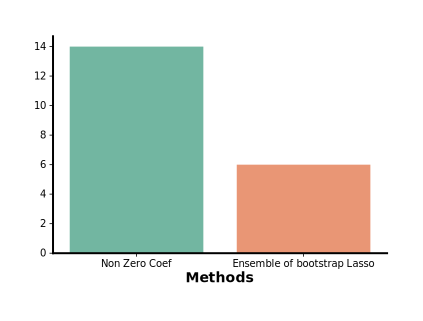

In [80]:
fig, ax = plt.subplots(figsize=(6, 4))


plt_data = (
    compare_metrics_df.query("type != 'single'")
    .sort_values("AUC", ascending=False)
    .groupby(
        [
            "disease",
            "omics",
        ]
    )
    .head(1)["type"]
    .value_counts()
)


sns.barplot(
    x=plt_data.index,
    y=plt_data.values,
    ax=ax,
    hue=plt_data.index,
    palette="Set2",
)
ax.set_xlabel("Methods")
ax.set_xticklabels(["Non Zero Coef", "Ensemble of bootstrap Lasso"])
save_fig(path=figdir / "compare_methods")

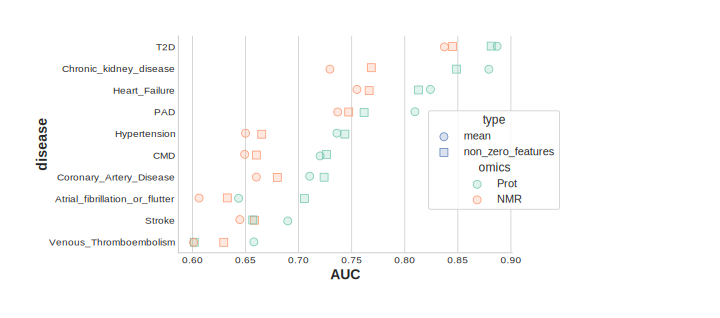

In [199]:
plt_data = compare_metrics_df.query("type != 'single'").sort_values(
    "AUC", ascending=False
)
from seaborn import axes_style

theme_dict = {**axes_style("whitegrid"), "grid.linestyle": "--"}


fig, ax = plt.subplots(figsize=(6, 4))
import seaborn.objects as so

p = (
    so.Plot(
        data=plt_data.reset_index(drop=True),
        y="disease",
        x="AUC",
        # y="type"
        marker="type",
        color="omics",
    )
    # .facet(row="omics")
    .add(so.Dots(alpha=0.9, pointsize=(8)), so.Jitter(0.1))
    .scale(
        color="Set2", marker=so.Nominal(["o", "s"], order=["mean", "non_zero_features"])
    )
    .theme(theme_dict)
    .on(ax)
    .plot()
)
save_fig(path=figdir / "compare_methods_scatter")

In [229]:
#  zscore for NMR and Prot

Prot_train = load_data(dataDir / "imputeData" / "Prot_train.feather")
NMR_train = load_data(dataDir / "imputeData" / "NMR_train.feather")
held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")

In [288]:
from collections import defaultdict
from functools import reduce


def get_score(df, coef):
    """
    coef: index be the features

    """
    score = df[coef.index.tolist()] @ coef

    assert score.shape[0] == df.shape[0]
    score.columns = ["score"]
    return score


compare_metrics_list = []
for disease_dir in diseaserawDir.glob("*"):
    disease_name = disease_dir.stem
    disease_df = load_data(disease_dir)

    disease_modelSaveDir = modelSaveDir / disease_name
    disease_modelSaveDir.mkdir(parents=True, exist_ok=True)

    final_need_cols = ["eid", "incident", "survTime", "date"]

    score_dict = defaultdict(lambda: defaultdict(dict))

    for name, omics_df in zip(["Prot", "NMR"], [Prot_train, NMR_train]):

        # load model
        # bootsrap_model = GLMNETBootsrapResult(
        #     modelLocalDir / disease_name / name / f"glmnet/{name}/
        # )

        # get best coef
        compare_metrics = (
            pd.read_csv(
                modelLocalDir / disease_name / name / f"glmnet/compare_metrics.csv"
            )
            .rename(columns={"Unnamed: 0": "type"})
            .query("type != 'single'")
            .sort_values("AUC", ascending=False)
        )
        best_type_name = compare_metrics["type"].iloc[0]

        # load coef
        if best_type_name == "mean":
            coef = (
                pd.read_csv(
                    modelLocalDir
                    / disease_name
                    / name
                    / f"glmnet/bootstrap/bootstrap_coef_df.csv",
                    index_col=0,
                )
                .mean(axis=1)
                .to_frame()
            )

        elif best_type_name == "non_zero_features":
            coef = pd.read_csv(
                modelLocalDir
                / disease_name
                / name
                / f"glmnet/non_zero_features/{name}/coef_df.csv",
                index_col=0,
            )

        train_data = omics_df[["eid", *coef.index]].copy()
        held_train_data = held_out_train[["eid", *coef.index]].copy()
        held_test_data = held_out_test[["eid", *coef.index]].copy()

        # zscore
        train_mean = train_data.iloc[:, 1:].mean()
        train_std = train_data.iloc[:, 1:].std()

        held_train_data.iloc[:, 1:] = (
            held_train_data.iloc[:, 1:] - train_mean
        ) / train_std
        held_test_data.iloc[:, 1:] = (
            held_test_data.iloc[:, 1:] - train_mean
        ) / train_std
        # get score
        train_data_score = get_score(train_data, coef)
        train_data_score.rename(columns={"score": name}, inplace=True)

        held_train_data_score = get_score(held_train_data, coef)
        held_train_data_score.rename(columns={"score": name}, inplace=True)

        held_test_data_score = get_score(held_test_data, coef)
        held_test_data_score.rename(columns={"score": name}, inplace=True)

        # merge and save
        # score_dict[name]["train"] = train_data[["eid"]].merge(
        #     train_data_score, left_index=True, right_index=True
        # )
        score_dict[name]["held_train"] = held_train_data[["eid"]].merge(
            held_train_data_score, left_index=True, right_index=True
        )
        score_dict[name]["held_test"] = held_test_data[["eid"]].merge(
            held_test_data_score, left_index=True, right_index=True
        )

    # train_score = reduce(
    #     lambda x, y: x.merge(y, on="eid", how="inner"),
    #     [v["train"] for v in score_dict.values()],
    # )
    held_train_score = reduce(
        lambda x, y: x.merge(y, on="eid", how="inner"),
        [v["held_train"] for v in score_dict.values()],
    )
    held_test_score = reduce(
        lambda x, y: x.merge(y, on="eid", how="inner"),
        [v["held_test"] for v in score_dict.values()],
    )

    # train_score = disease_df[final_need_cols].merge(train_score, on="eid", how="inner")
    # held_train_score = disease_df[final_need_cols].merge(
    #     held_train_score, on="eid", how="inner"
    # )
    # held_test_score = disease_df[final_need_cols].merge(
    #     held_test_score, on="eid", how="inner"
    # )
    # print(
    #     f"disease_name: {disease_name}, held_train_score: {held_train_score.shape[0]}, held_test_score: {held_test_score.shape[0]}"
    # )

    # load RF
    RF_held_train_score = load_data(disease_modelSaveDir / "held_out_train.feather")
    RF_held_test_score = load_data(disease_modelSaveDir / "held_out_test.feather")

    # merge RF and NMR and Prot
    held_train_score_all = RF_held_train_score.merge(
        held_train_score, on="eid", how="inner"
    )
    held_test_score_all = RF_held_test_score.merge(
        held_test_score, on="eid", how="inner"
    )

    # save
    held_train_score_all.to_feather(
        disease_modelSaveDir / "held_out_train_final.feather"
    )
    held_test_score_all.to_feather(disease_modelSaveDir / "held_out_test_final.feather")

    # save Prot and NMR
    held_train_score.to_feather(
        disease_modelSaveDir / "held_out_train_NMR_Prot.feather"
    )
    held_test_score.to_feather(disease_modelSaveDir / "held_out_test_NMR_Prot.feather")

## Add PRS

In [108]:
FinalModelDir = outputDir / "05-FinnalModel"
FinalModelDir.mkdir(parents=True, exist_ok=True)

In [109]:
from collections import defaultdict
from functools import reduce
from config import *


PRSDir = dataDir / "rawPRS"

# combine PRS data
final_disease_dict = {}
for disease, c_disease_dict in env_disease_dict.items():
    if disease == "CMD":
        continue
    c_disease_final_model_Dir = FinalModelDir / disease
    c_disease_final_model_Dir.mkdir(parents=True, exist_ok=True)

    prs_df = load_data(PRSDir / f"{disease}.tsv")
    prs_df.columns = ["eid", "PRS"]
    prs_df["eid"] = prs_df["eid"].astype(str)

    train = c_disease_dict["train"].copy().merge(prs_df, how="inner", on="eid")

    test = c_disease_dict["test"].copy().merge(prs_df, how="inner", on="eid")
    # combine PRS
    train.to_feather(
        c_disease_final_model_Dir / "held_out_train_final_ensemble.feather"
    )
    test.to_feather(c_disease_final_model_Dir / "held_out_test_final_ensemble.feather")
    final_disease_dict[disease] = {
        "train": train,
        "test": test,
        "models": model,
    }

In [110]:
pickle.dump(final_disease_dict, open(FinalModelDir / "final_disease_dict.pkl", "wb"))

In [10]:
prs_df

,eid,PRS
0,-7.3127793,1.0
1,-7.4054122,1.0
2,-8.0931304,0.0
3,-8.036690752,1.0
4,-7.3759644,0.0
...,...,...
487188,-7.4396927,0.0
487189,-6.799877,0.0
487190,-7.8328491,0.0
487191,-7.6491825,0.0


In [281]:
# train_data[coef.index]
pd.read_csv(
    modelLocalDir / disease_name / name / f"glmnet/bootstrap/bootstrap_coef_df.csv",
    index_col=0,
).mean(axis=1).to_frame()

,0
feature,
A1BG,-0.000942
AAMDC,-0.003310
AARSD1,0.000000
ABCA2,-0.001260
ABHD14B,0.000000
...,...
ZNRD2,0.000000
ZNRF4,0.000272
ZP3,0.000000


In [280]:
pd.read_csv(
    modelLocalDir
    / disease_name
    / name
    / f"glmnet/non_zero_features/{name}/coef_df.csv",
    index_col=0,
)

,coef_
A1BG,-0.091136
AAMDC,-0.033878
ABCA2,-0.024477
ACAA1,-0.047347
ACAN,-0.049185
...,...
ZBP1,0.043434
ZBTB16,0.061338
ZHX2,-0.010419
ZNRF4,0.021154


In [247]:
get_score(held_train_data, coef)

,score
0,-0.828809
1,-0.953232
2,0.737555
3,-0.246725
4,-0.531890
...,...
9147,0.988224
9148,-0.183823
9149,0.479746
9150,0.248691


In [223]:
pd.read_csv(
    modelLocalDir
    / disease_name
    / name
    / f"glmnet/non_zero_features/{name}/coef_df.csv",
    index_col=0,
)

,coef_
AAMDC,0.016110
ABO,0.023214
ACAN,0.004548
ACE2,0.035820
ACOX1,-0.065051
...,...
ZNF75D,0.015343
ZNF830,-0.012542
ZNRF4,0.043161
ZP3,0.008564
